In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mantasu/face-attributes-grouped")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chathui3628
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mantasu/face-attributes-grouped


100%|██████████| 1.50G/1.50G [00:09<00:00, 164MB/s]


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from PIL import Image

In [9]:
# 1. CONFIGURATION
BASE_DIR = '/content/face-attributes-grouped/face-attributes-grouped'  # change if needed
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR   = os.path.join(BASE_DIR, 'val')
TEST_DIR  = os.path.join(BASE_DIR, 'test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 25
EPOCHS_FINE = 75

# Only train 'eyeware_model' category
CATEGORY = 'eyewear'
CLASSES =  ['eyecover', 'eyeglasses', 'no_eyewear', 'sunglasses']

In [6]:
# 2. Data generators
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen_val = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    os.path.join(TRAIN_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=True
)
val_gen = datagen_val.flow_from_directory(
    os.path.join(VAL_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)
test_gen = datagen_val.flow_from_directory(
    os.path.join(TEST_DIR, CATEGORY),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=False
)

Found 4000 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [7]:
# 3. Build model
def build_model(num_classes, input_shape=(224,224,3)):
    base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=out)
    return model

model = build_model(num_classes=len(CLASSES), input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Phase 1: train head only
for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False
model.layers[-1].trainable = True  # only final Dense

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(f'best_{CATEGORY}_phase1.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_HEAD,
    callbacks=cb1
)

# Phase 2: fine-tune top layers
model.load_weights(f'best_{CATEGORY}_phase1.h5')
for layer in model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cb2 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    ModelCheckpoint(f'best_{CATEGORY}_final.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE,
    callbacks=cb2
)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.7798 - loss: 0.5975
Epoch 1: val_loss improved from inf to 0.47078, saving model to best_eyewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 534ms/step - accuracy: 0.7799 - loss: 0.5972 - val_accuracy: 0.8375 - val_loss: 0.4708 - learning_rate: 0.0010
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8090 - loss: 0.5133
Epoch 2: val_loss improved from 0.47078 to 0.46921, saving model to best_eyewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 461ms/step - accuracy: 0.8090 - loss: 0.5133 - val_accuracy: 0.8475 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8059 - loss: 0.5175
Epoch 3: val_loss improved from 0.46921 to 0.42424, saving model to best_eyewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 476ms/step - accuracy: 0.8059 - loss: 0.5174 - val_accuracy: 0.8450 - val_loss: 0.4242 - learning_rate: 0.0010
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8339 - loss: 0.4756
Epoch 4: val_loss improved from 0.42424 to 0.40429, saving model to best_eyewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - accuracy: 0.8339 - loss: 0.4756 - val_accuracy: 0.8600 - val_loss: 0.4043 - learning_rate: 0.0010
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8123 - loss: 0.5053
Epoch 5: val_loss improved from 0.40429 to 0.38336, saving model to best_eyewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 476ms/step - accuracy: 0.8123 - loss: 0.5052 - val_accuracy: 0.8700 - val_loss: 0.3834 - learning_rate: 0.0010
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8239 - loss: 0.4618
Epoch 6: val_loss did not improve from 0.38336
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 461ms/step - accuracy: 0.8240 - loss: 0.4617 - val_accuracy: 0.8650 - val_loss: 0.4007 - learning_rate: 0.0010
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8386 - loss: 0.4527
Epoch 7: val_loss did not improve from 0.38336
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - accuracy: 0.8386 - loss: 0.4528 - val_accuracy: 0.8600 - val_loss: 0.4066 - learning_rate: 0.0010
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8338 - loss: 0.4750
Epoch 8: val_loss improved from 0.38336 to 0.37341, saving model to best_eyewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 463ms/step - accuracy: 0.8338 - loss: 0.4747 - val_accuracy: 0.8725 - val_loss: 0.3734 - learning_rate: 0.0010
Epoch 9/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8490 - loss: 0.4250
Epoch 9: val_loss did not improve from 0.37341
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 462ms/step - accuracy: 0.8489 - loss: 0.4252 - val_accuracy: 0.8650 - val_loss: 0.3938 - learning_rate: 0.0010
Epoch 10/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8416 - loss: 0.4310
Epoch 10: val_loss did not improve from 0.37341
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 466ms/step - accuracy: 0.8416 - loss: 0.4311 - val_accuracy: 0.8625 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 11/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8300 - loss: 0.4526
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_loss did not improve from 0.37341
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - accuracy: 0.8301 - loss: 0.4525 - v

125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - accuracy: 0.8502 - loss: 0.4097 - val_accuracy: 0.8700 - val_loss: 0.3720 - learning_rate: 5.0000e-04
Epoch 14/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8478 - loss: 0.4116
Epoch 14: val_loss did not improve from 0.37204
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 470ms/step - accuracy: 0.8477 - loss: 0.4117 - val_accuracy: 0.8675 - val_loss: 0.3846 - learning_rate: 5.0000e-04
Epoch 15/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8486 - loss: 0.4166
Epoch 15: val_loss improved from 0.37204 to 0.36345, saving model to best_eyewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - accuracy: 0.8486 - loss: 0.4166 - val_accuracy: 0.8800 - val_loss: 0.3635 - learning_rate: 5.0000e-04
Epoch 16/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8475 - loss: 0.4268
Epoch 16: val_loss did not improve from 0.36345
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 470ms/step - accuracy: 0.8475 - loss: 0.4268 - val_accuracy: 0.8725 - val_loss: 0.3685 - learning_rate: 5.0000e-04
Epoch 17/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8387 - loss: 0.4219
Epoch 17: val_loss did not improve from 0.36345
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - accuracy: 0.8387 - loss: 0.4220 - val_accuracy: 0.8725 - val_loss: 0.3782 - learning_rate: 5.0000e-04
Epoch 18/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.8287 - loss: 0.4393
Epoch 18: val_loss improved from 0.36345 to 0.35932, saving model to best_eyewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 471ms/step - accuracy: 0.8288 - loss: 0.4392 - val_accuracy: 0.8725 - val_loss: 0.3593 - learning_rate: 5.0000e-04
Epoch 19/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8570 - loss: 0.4220
Epoch 19: val_loss did not improve from 0.35932
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 462ms/step - accuracy: 0.8570 - loss: 0.4219 - val_accuracy: 0.8700 - val_loss: 0.3678 - learning_rate: 5.0000e-04
Epoch 20/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8417 - loss: 0.4290
Epoch 20: val_loss did not improve from 0.35932
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 466ms/step - accuracy: 0.8417 - loss: 0.4289 - val_accuracy: 0.8700 - val_loss: 0.3728 - learning_rate: 5.0000e-04
Epoch 21/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8367 - loss: 0.4350
Epoch 21: val_loss improved from 0.35932 to 0.35659, saving model to best_eyewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 468ms/step - accuracy: 0.8367 - loss: 0.4349 - val_accuracy: 0.8800 - val_loss: 0.3566 - learning_rate: 5.0000e-04
Epoch 22/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8331 - loss: 0.4334
Epoch 22: val_loss improved from 0.35659 to 0.35636, saving model to best_eyewear_phase1.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 466ms/step - accuracy: 0.8332 - loss: 0.4334 - val_accuracy: 0.8875 - val_loss: 0.3564 - learning_rate: 5.0000e-04
Epoch 23/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8393 - loss: 0.4235
Epoch 23: val_loss did not improve from 0.35636
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - accuracy: 0.8394 - loss: 0.4234 - val_accuracy: 0.8775 - val_loss: 0.3645 - learning_rate: 5.0000e-04
Epoch 24/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8611 - loss: 0.4220
Epoch 24: val_loss did not improve from 0.35636
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - accuracy: 0.8611 - loss: 0.4219 - val_accuracy: 0.8800 - val_loss: 0.3638 - learning_rate: 5.0000e-04
Epoch 25/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8502 - loss: 0.4001
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 25: val_loss did not improve from 0.35636
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 463ms/step - accuracy: 0.8502 - lo

125/125 ━━━━━━━━━━━━━━━━━━━━ 136s 661ms/step - accuracy: 0.7113 - loss: 0.7742 - val_accuracy: 0.9050 - val_loss: 0.2687 - learning_rate: 1.0000e-05
Epoch 2/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8583 - loss: 0.4128
Epoch 2: val_loss improved from 0.26869 to 0.22184, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 592ms/step - accuracy: 0.8583 - loss: 0.4126 - val_accuracy: 0.9175 - val_loss: 0.2218 - learning_rate: 1.0000e-05
Epoch 3/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8969 - loss: 0.3208
Epoch 3: val_loss improved from 0.22184 to 0.20184, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 604ms/step - accuracy: 0.8970 - loss: 0.3206 - val_accuracy: 0.9275 - val_loss: 0.2018 - learning_rate: 1.0000e-05
Epoch 4/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9006 - loss: 0.2761
Epoch 4: val_loss improved from 0.20184 to 0.17942, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 597ms/step - accuracy: 0.9007 - loss: 0.2759 - val_accuracy: 0.9325 - val_loss: 0.1794 - learning_rate: 1.0000e-05
Epoch 5/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9266 - loss: 0.2255
Epoch 5: val_loss improved from 0.17942 to 0.16620, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 595ms/step - accuracy: 0.9266 - loss: 0.2254 - val_accuracy: 0.9375 - val_loss: 0.1662 - learning_rate: 1.0000e-05
Epoch 6/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9384 - loss: 0.1965
Epoch 6: val_loss improved from 0.16620 to 0.15797, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 599ms/step - accuracy: 0.9384 - loss: 0.1965 - val_accuracy: 0.9375 - val_loss: 0.1580 - learning_rate: 1.0000e-05
Epoch 7/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9365 - loss: 0.1930
Epoch 7: val_loss improved from 0.15797 to 0.15084, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 598ms/step - accuracy: 0.9366 - loss: 0.1928 - val_accuracy: 0.9425 - val_loss: 0.1508 - learning_rate: 1.0000e-05
Epoch 8/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9527 - loss: 0.1468
Epoch 8: val_loss improved from 0.15084 to 0.14309, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 596ms/step - accuracy: 0.9526 - loss: 0.1468 - val_accuracy: 0.9500 - val_loss: 0.1431 - learning_rate: 1.0000e-05
Epoch 9/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9535 - loss: 0.1480
Epoch 9: val_loss improved from 0.14309 to 0.13740, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 598ms/step - accuracy: 0.9535 - loss: 0.1481 - val_accuracy: 0.9575 - val_loss: 0.1374 - learning_rate: 1.0000e-05
Epoch 10/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9536 - loss: 0.1465
Epoch 10: val_loss improved from 0.13740 to 0.13395, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 598ms/step - accuracy: 0.9537 - loss: 0.1464 - val_accuracy: 0.9550 - val_loss: 0.1339 - learning_rate: 1.0000e-05
Epoch 11/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9562 - loss: 0.1354
Epoch 11: val_loss improved from 0.13395 to 0.13107, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 590ms/step - accuracy: 0.9562 - loss: 0.1354 - val_accuracy: 0.9550 - val_loss: 0.1311 - learning_rate: 1.0000e-05
Epoch 12/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9702 - loss: 0.1012
Epoch 12: val_loss did not improve from 0.13107
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 589ms/step - accuracy: 0.9702 - loss: 0.1013 - val_accuracy: 0.9525 - val_loss: 0.1324 - learning_rate: 1.0000e-05
Epoch 13/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9664 - loss: 0.1031
Epoch 13: val_loss improved from 0.13107 to 0.12481, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 597ms/step - accuracy: 0.9664 - loss: 0.1031 - val_accuracy: 0.9625 - val_loss: 0.1248 - learning_rate: 1.0000e-05
Epoch 14/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9673 - loss: 0.1005
Epoch 14: val_loss did not improve from 0.12481
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 586ms/step - accuracy: 0.9673 - loss: 0.1005 - val_accuracy: 0.9600 - val_loss: 0.1251 - learning_rate: 1.0000e-05
Epoch 15/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9741 - loss: 0.0838
Epoch 15: val_loss improved from 0.12481 to 0.12378, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 595ms/step - accuracy: 0.9741 - loss: 0.0838 - val_accuracy: 0.9675 - val_loss: 0.1238 - learning_rate: 1.0000e-05
Epoch 16/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9769 - loss: 0.0758
Epoch 16: val_loss improved from 0.12378 to 0.11886, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 595ms/step - accuracy: 0.9769 - loss: 0.0758 - val_accuracy: 0.9650 - val_loss: 0.1189 - learning_rate: 1.0000e-05
Epoch 17/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9808 - loss: 0.0649
Epoch 17: val_loss did not improve from 0.11886
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 586ms/step - accuracy: 0.9808 - loss: 0.0649 - val_accuracy: 0.9575 - val_loss: 0.1215 - learning_rate: 1.0000e-05
Epoch 18/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9801 - loss: 0.0697
Epoch 18: val_loss did not improve from 0.11886
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 588ms/step - accuracy: 0.9801 - loss: 0.0697 - val_accuracy: 0.9600 - val_loss: 0.1231 - learning_rate: 1.0000e-05
Epoch 19/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9769 - loss: 0.0650
Epoch 19: val_loss improved from 0.11886 to 0.11496, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 591ms/step - accuracy: 0.9769 - loss: 0.0650 - val_accuracy: 0.9650 - val_loss: 0.1150 - learning_rate: 1.0000e-05
Epoch 20/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9810 - loss: 0.0530
Epoch 20: val_loss did not improve from 0.11496
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 587ms/step - accuracy: 0.9810 - loss: 0.0530 - val_accuracy: 0.9675 - val_loss: 0.1169 - learning_rate: 1.0000e-05
Epoch 21/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9830 - loss: 0.0506
Epoch 21: val_loss improved from 0.11496 to 0.11351, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 594ms/step - accuracy: 0.9830 - loss: 0.0506 - val_accuracy: 0.9625 - val_loss: 0.1135 - learning_rate: 1.0000e-05
Epoch 22/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9838 - loss: 0.0521
Epoch 22: val_loss did not improve from 0.11351
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 585ms/step - accuracy: 0.9838 - loss: 0.0521 - val_accuracy: 0.9650 - val_loss: 0.1185 - learning_rate: 1.0000e-05
Epoch 23/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9855 - loss: 0.0446
Epoch 23: val_loss did not improve from 0.11351
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 589ms/step - accuracy: 0.9855 - loss: 0.0445 - val_accuracy: 0.9625 - val_loss: 0.1140 - learning_rate: 1.0000e-05
Epoch 24/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9884 - loss: 0.0408
Epoch 24: val_loss improved from 0.11351 to 0.11066, saving model to best_eyewear_final.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 594ms/step - accuracy: 0.9884 - loss: 0.0407 - val_accuracy: 0.9650 - val_loss: 0.1107 - learning_rate: 1.0000e-05
Epoch 25/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9903 - loss: 0.0378
Epoch 25: val_loss did not improve from 0.11066
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 584ms/step - accuracy: 0.9903 - loss: 0.0378 - val_accuracy: 0.9650 - val_loss: 0.1121 - learning_rate: 1.0000e-05
Epoch 26/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9879 - loss: 0.0329
Epoch 26: val_loss did not improve from 0.11066
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 585ms/step - accuracy: 0.9879 - loss: 0.0329 - val_accuracy: 0.9675 - val_loss: 0.1144 - learning_rate: 1.0000e-05
Epoch 27/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9938 - loss: 0.0253
Epoch 27: val_loss did not improve from 0.11066
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 584ms/step - accuracy: 0.9938 - loss: 0.0254 - val_accuracy: 0.9675 - val_loss: 0.1129 - learning_rate: 1.0000e-

125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 639ms/step - accuracy: 0.9879 - loss: 0.0372 - val_accuracy: 0.9600 - val_loss: 0.1088 - learning_rate: 5.0000e-06
Epoch 31/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9898 - loss: 0.0296
Epoch 31: val_loss did not improve from 0.10882
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 584ms/step - accuracy: 0.9897 - loss: 0.0296 - val_accuracy: 0.9625 - val_loss: 0.1123 - learning_rate: 5.0000e-06
Epoch 32/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9921 - loss: 0.0313
Epoch 32: val_loss did not improve from 0.10882
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 589ms/step - accuracy: 0.9921 - loss: 0.0313 - val_accuracy: 0.9600 - val_loss: 0.1141 - learning_rate: 5.0000e-06
Epoch 33/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.9932 - loss: 0.0202
Epoch 33: val_loss did not improve from 0.10882
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 585ms/step - accuracy: 0.9932 - loss: 0.0202 - val_accuracy: 0.9625 - val_loss: 0.1127 - learning_rate: 5.0000e-

In [12]:
SAVE_PATH = "/content/drive/MyDrive/eyeware_model"
os.makedirs(SAVE_PATH, exist_ok=True)

model.save(f"{SAVE_PATH}/eyeware_model.h5")
print("\nModel saved to:", f"{SAVE_PATH}/eyeware_model.h5")


Model saved to: /content/drive/MyDrive/eyeware_model/eyeware_model.h5


In [16]:
# ---------------------------------------
#  ⭐  TEST / TRAIN / VAL ACCURACY
# ---------------------------------------

# Load best final model weights
best_model_path = f"best_{CATEGORY}_final.h5"
print("Loading:", best_model_path)
model.load_weights(best_model_path)

# Evaluate Train Accuracy
train_loss, train_acc = model.evaluate(train_gen, verbose=1)
print(f"\n>>> TRAIN ACCURACY: {train_acc * 100:.2f}%")

# Evaluate Validation Accuracy
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f">>> VALIDATION ACCURACY: {val_acc * 100:.2f}%")

# Evaluate Test Accuracy
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f">>> TEST ACCURACY: {test_acc * 100:.2f}%")


Loading: best_eyewear_final.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - accuracy: 0.9978 - loss: 0.0094

>>> TRAIN ACCURACY: 99.77%
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9517 - loss: 0.1161
>>> VALIDATION ACCURACY: 96.00%
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9598 - loss: 0.1614
>>> TEST ACCURACY: 96.50%


In [17]:
# 7. FINAL PREDICTION AFTER TRAINING
# ---------------------------
def predict_accessories(img_path, threshold=0.30):
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    arr = np.expand_dims(np.array(img)/255.0, axis=0)

    probs = model.predict(arr)[0]

    detected = [CLASSES[i] for i, p in enumerate(probs) if p >= threshold]

    if len(detected) == 0:
        return "Person is wearing no accessories"
    return "Person is wearing " + " and ".join(detected)

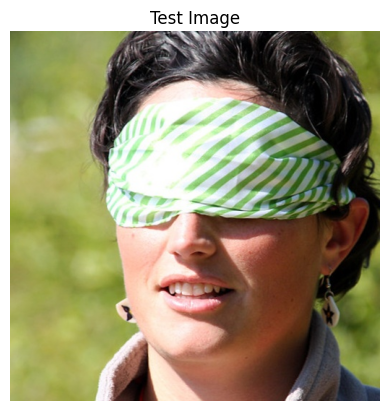


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Person is wearing eyecover


In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/test/eyewear/eyecover/3620719082_b552c2b903_b.jpg"

# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


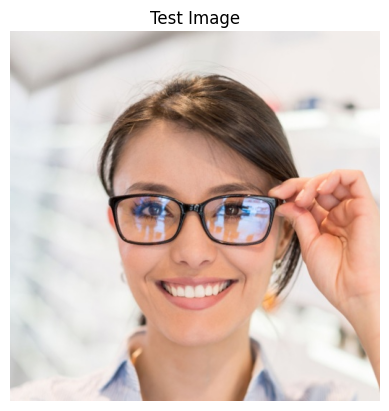


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Person is wearing eyeglasses


In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/test/eyewear/eyeglasses/1280-506292872-woman-trying-glasses-at-the-optics.jpg"
# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


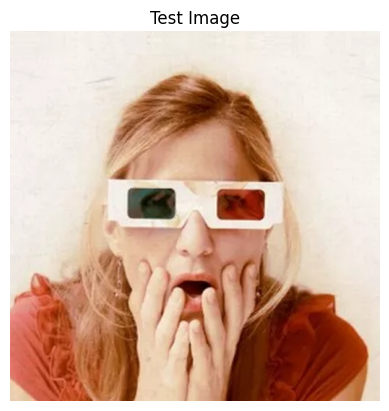


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Person is wearing sunglasses


In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/test/eyewear/sunglasses/122294809.jpg"

# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


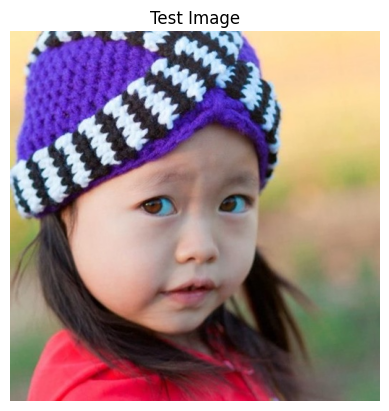


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Person is wearing no_eyewear


In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/test/eyewear/no_eyewear/236574fb61e186e6bb22865ab2f360b2.jpg"

# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


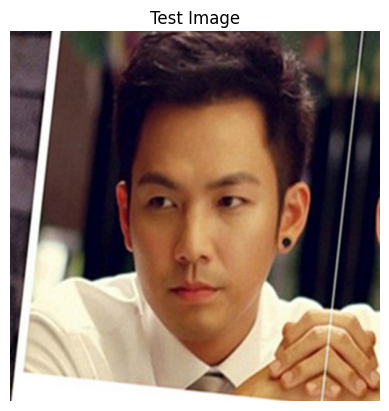


FINAL PREDICTION RESULT:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Person is wearing no_eyewear


In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

IMAGE_FOR_FINAL_TEST = "/content/face-attributes-grouped/face-attributes-grouped/test/accessories/earrings/1Pair-Men-Magnet-Stud-Earrings-Non-Piercing-Clip-On-Round-Earring-Black-Magnetic-Earrings-For-Mens.jpg"
# Display image
img = mpimg.imread(IMAGE_FOR_FINAL_TEST)
plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Prediction
print("\nFINAL PREDICTION RESULT:")
print(predict_accessories(IMAGE_FOR_FINAL_TEST))


In [24]:
SAVE_PATH = "/content/drive/MyDrive/eyeware_model"
os.makedirs(SAVE_PATH, exist_ok=True)

model.save(f"{SAVE_PATH}/new_eyeware_model.h5")
print("\nModel saved to:", f"{SAVE_PATH}/new_eyeware_model.h5")


Model saved to: /content/drive/MyDrive/eyeware_model/new_eyeware_model.h5
